# ARXIV Keyword Project

In this small example project, we will find out which topics have been increasingly published in computer science recently.

First a few imports and a logger setup:

In [2]:
!pip install arxiv

In [3]:
!pip install keybert

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import webbrowser
from tqdm.notebook import tqdm
import time
from datetime import datetime, timedelta

import arxiv, logging, keybert
from collections import Counter
from wordcloud import WordCloud


/home/hans/Documents/ds_project/project 1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
logging.basicConfig(level=logging.INFO)

In [4]:
url = 'https://arxiv.org/search/?query=Deep+learning&searchtype=all&abstracts=show&order=-announced_date_first&size=200'
# Open arxiv website for deep learning papers
webbrowser.open_new_tab(url)

True

In [5]:
url = 'https://arxiv.org/search/?query=Deep+learning&searchtype=all&abstracts=show&order=-announced_date_first&size=200'
# Open arxiv website for deep learning papers
webbrowser.open_new_tab(url)

# Create a client instance
client = arxiv.Client()

## 1.  Collecting data

1. First we get the meta data for the last 1000 papers from the Computer Science category. For this we use the [arxiv python library](https://pypi.org/project/arxiv/), which in turn accesses the official arxiv API. The results are then sorted from the newest to the oldest submission date.


2. The function search.results() actually queries the data and then inserts it in a FOR loop into a list of dictionaries with the meta data that we still need.

In [ ]:
def fetch_papers_by_subcategory(subcategories, papers_per_category=50):
    """Fetch papers from multiple CS subcategories to get more diverse results"""
    all_results = []

    for subcat in subcategories:
        print(f"Fetching papers from {subcat}...")
        search = arxiv.Search(
            query=f'cat:{subcat}',
            sort_by=arxiv.SortCriterion.SubmittedDate,
            max_results=papers_per_category,
            sort_order=arxiv.SortOrder.Descending
        )

        try:
            for i, paper in enumerate(client.results(search)):
                meta_data = {
                    'title': paper.title,
                    'abstract': paper.summary,
                    'authors': paper.authors,
                    'date_published': paper.published,
                    'category': subcat
                }
                all_results.append(meta_data)

                if (i + 1) % 10 == 0:
                    print(f"  Fetched {i + 1} papers from {subcat}...")

            time.sleep(1)  # Respectful delay between categories

        except Exception as e:
            print(f"Error with {subcat}: {e}")
            print(f"Successfully fetched {len([r for r in all_results if r['category'] == subcat])} papers from {subcat}")
            continue

    return all_results

Method 2

In [6]:
def fetch_papers_by_date_ranges():
    """Alternative approach: fetch papers from different date ranges"""
    all_results = []

    # Define date ranges (last 2 years, split into quarters)
    end_date = datetime.now()
    date_ranges = []
    for months_back in range(0, 24, 3):  # 3-month intervals for 2 years
        range_end = end_date - timedelta(days=months_back*30)
        range_start = end_date - timedelta(days=(months_back+3)*30)
        date_ranges.append((range_start, range_end))

    for i, (start_date, end_date_range) in enumerate(date_ranges):
        print(f"Fetching papers from {start_date.strftime('%Y-%m')} to {end_date_range.strftime('%Y-%m')}...")

        # Format dates for arXiv query
        start_str = start_date.strftime('%Y%m%d')
        end_str = end_date_range.strftime('%Y%m%d')

        search = arxiv.Search(
            query=f'cat:cs.* AND submittedDate:[{start_str} TO {end_str}]',
            sort_by=arxiv.SortCriterion.SubmittedDate,
            max_results=80,  # Smaller batches per date range
            sort_order=arxiv.SortOrder.Descending
        )

        try:
            batch_count = 0
            for paper in client.results(search):
                meta_data = {
                    'title': paper.title,
                    'abstract': paper.summary,
                    'authors': paper.authors,
                    'date_published': paper.published,
                    'date_range': f"{start_date.strftime('%Y-%m')} to {end_date_range.strftime('%Y-%m')}"
                }
                all_results.append(meta_data)
                batch_count += 1

                if batch_count % 20 == 0:
                    print(f"  Fetched {batch_count} papers from this date range...")

            time.sleep(0.5)  # Small delay between date ranges

        except Exception as e:
            print(f"Error with date range {start_date.strftime('%Y-%m')} to {end_date_range.strftime('%Y-%m')}: {e}")
            continue

        # Stop if we have enough papers
        if len(all_results) >= 500:
            print(f"Reached target of ~500 papers with {len(all_results)} papers")
            break

    return all_results

In [ ]:
# Strategy 1: Fetch from multiple CS subcategories
print("=== Strategy 1: Multiple CS Subcategories ===")
cs_subcategories = [
    'cs.AI',    # Artificial Intelligence
    'cs.LG',    # Machine Learning
    'cs.CV',    # Computer Vision
    'cs.CL',    # Computation and Language
    'cs.DB',    # Databases
    'cs.DC',    # Distributed Computing
    'cs.DS',    # Data Structures and Algorithms
    'cs.HC',    # Human-Computer Interaction
    'cs.IR',    # Information Retrieval
    'cs.NI',    # Networking
    'cs.SE',    # Software Engineering
    'cs.SY'     # Systems and Control
]

In [9]:
results_method1 = fetch_papers_by_subcategory(cs_subcategories, papers_per_category=50)
print(f"Method 1 total: {len(results_method1)} papers\n")

NameError: name 'fetch_papers_by_subcategory' is not defined

In [8]:
# If Method 1 doesn't get enough, try Method 2
if len(results_method1) < 400:
    print("=== Strategy 2: Date Range Approach ===")
    results_method2 = fetch_papers_by_date_ranges()
    print(f"Method 2 total: {len(results_method2)} papers\n")

    # Combine and deduplicate
    all_results = results_method1 + results_method2
    # Remove duplicates based on title
    seen_titles = set()
    unique_results = []
    for paper in all_results:
        if paper['title'] not in seen_titles:
            seen_titles.add(paper['title'])
            unique_results.append(paper)

    results = unique_results[:500]  # Take first 500
else:
    results = results_method1

print(f"Final total: {len(results)} papers")

NameError: name 'results_method1' is not defined

In [10]:
results_df = pd.DataFrame(results)
results_df.set_index(results_df['date_published'], inplace=True)
results_df

NameError: name 'results' is not defined

# 2. Generate keywords

Unfortunately, Arxiv does not offer any keywords, so we use a deep learning method to extract the keywords from the respective abstracts of the papers. Fortunately, there is a Python library, [KeyBERT](https://maartengr.github.io/KeyBERT/), which provides a fully trained model directly, which we now load into our notebook.

In [11]:
model = keybert.KeyBERT()

Cancellation requested; stopping current tasks.


KeyboardInterrupt: 

Next, we apply KeyBERT to the title combined with the abstract of each paper and **store keywords consisting of one and two words**.


<span style="color:red">This may take a little while</span>!

In [12]:
keywords_list = []
for row_i in tqdm(range(results_df.shape[0])):
    row = results_df.iloc[row_i]
    keywords = []
    title_abstract = row['title'] + ' ' + row['abstract']
    keywords.append(model.extract_keywords(title_abstract,
                       keyphrase_ngram_range = (1,1)))
    keywords.append(model.extract_keywords(title_abstract,
                       keyphrase_ngram_range = (1,2)))
    keywords_list.append(keywords)

NameError: name 'results_df' is not defined

The keywords are added to the DataFrame as a separate column.

In [ ]:
results_df['keywords'] = keywords_list

In [ ]:
results_df

,title,abstract,authors,date_published,keywords
date_published,,,,,
2024-02-22 18:59:58+00:00,PALO: A Polyglot Large Multimodal Model for 5B...,In pursuit of more inclusive Vision-Language M...,"[Muhammad Maaz, Hanoona Rasheed, Abdelrahman S...",2024-02-22 18:59:58+00:00,"[[(multilingual, 0.4953), (multimodal, 0.4922)..."
2024-02-22 18:59:56+00:00,Cameras as Rays: Pose Estimation via Ray Diffu...,Estimating camera poses is a fundamental task ...,"[Jason Y. Zhang, Amy Lin, Moneish Kumar, Tzu-H...",2024-02-22 18:59:56+00:00,"[[(pose, 0.4211), (poses, 0.3985), (cameras, 0..."
2024-02-22 18:59:53+00:00,Demographic Bias of Expert-Level Vision-Langua...,Advances in artificial intelligence (AI) have ...,"[Yuzhe Yang, Yujia Liu, Xin Liu, Avanti Gulhan...",2024-02-22 18:59:53+00:00,"[[(bias, 0.3745), (biases, 0.3423), (ai, 0.329..."
2024-02-22 18:59:24+00:00,Fine-Tuning Enhances Existing Mechanisms: A Ca...,Fine-tuning on generalized tasks such as instr...,"[Nikhil Prakash, Tamar Rott Shaham, Tal Haklay...",2024-02-22 18:59:24+00:00,"[[(entity, 0.3534), (tracking, 0.3499), (seman..."
2024-02-22 18:59:24+00:00,WeakSAM: Segment Anything Meets Weakly-supervi...,Weakly supervised visual recognition using ine...,"[Lianghui Zhu, Junwei Zhou, Yan Liu, Xin Hao, ...",2024-02-22 18:59:24+00:00,"[[(supervised, 0.4445), (regularization, 0.355..."
...,...,...,...,...,...
2024-02-21 18:36:26+00:00,Real-time 3D-aware Portrait Editing from a Sin...,"This work presents 3DPE, a practical tool that...","[Qingyan Bai, Yinghao Xu, Zifan Shi, Hao Ouyan...",2024-02-21 18:36:26+00:00,"[[(portrait, 0.4905), (editing, 0.441), (3d, 0..."
2024-02-21 18:35:27+00:00,Asymptotics of Learning with Deep Structured (...,For a large class of feature maps we provide a...,"[Dominik Schröder, Daniil Dmitriev, Hugo Cui, ...",2024-02-21 18:35:27+00:00,"[[(neural, 0.4153), (networks, 0.3634), (learn..."
2024-02-21 18:25:04+00:00,Generative Adversarial Models for Extreme Down...,Addressing the challenges of climate change re...,"[Guiye Li, Guofeng Cao]",2024-02-21 18:25:04+00:00,"[[(gans, 0.4554), (downscaling, 0.4483), (gan,..."


The keywords list is now a list of lists of keywords, to make it as easy as possible to count the keywords, we convert it into just a list of keywords using this flatten function:

In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [ ]:
flattened_keywords = flatten(flatten(keywords_list))

In [ ]:
flattened_keywords = [item[0] for item in flattened_keywords]

With the help of the python set function we can count the unique keywords in the entire list.

In [ ]:
len(flattened_keywords)

4000

In [ ]:
len(set(flattened_keywords))

3040

In [ ]:
flattened_keywords

#### Data set from keywords only
Now we search for the most frequent keywords and save them in a separate DataFrame, we filter out words that only occur once and then sort the whole thing in descending order of frequency.

In [ ]:
keywords_df = pd.DataFrame()
keywords_df['words'] = Counter(flattened_keywords).keys()
keywords_df['numbers'] = Counter(flattened_keywords).values()
frequent_words = keywords_df.loc[keywords_df['numbers'] > 1].sort_values(by='numbers', ascending=False)
frequent_words

,words,numbers
185,learning,31
3,language,23
68,attention,22
35,language models,20
104,visual,14
...,...,...
915,diversity,2
918,imitation learning,2
941,intrusion,2
968,digitalization,2


# 3. Visualisation of the data

And now we can visualise the whole thing as a word cloud directly from the counter.

In [ ]:
wordcloud = WordCloud(background_color="white",
                      width=2500,
                      height=1000,
                      scale=2.0,
                      min_font_size=6).fit_words(dict(Counter(flattened_keywords))).to_file('arxiv_word_cloud.png')

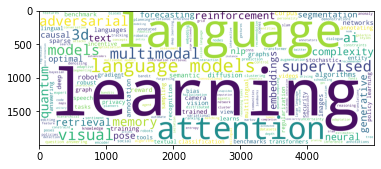

In [ ]:
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Exercises
0. Check, if realy the most popular keyphrases only contain one word, or if the two word keyphrases are not incluced in this plot.

1. Try to create the WordCloud directly from the titles and/or abstracts of the papers without KeyBERT and compare the result. Are the most frequently used words the same as the keywords? If not, what is the problem and how could this be easily avoided? *Hint: Stop Words (also directly in the [word cloud bib](https://amueller.github.io/word_cloud/index.html))*

#### 2. Keyword Analysis from Paper Titles

1. Preprocess the titles by removing stopwords and punctuation. Then extract the **top 20 unigrams** (single words) and visualize them.

2. Visually plot the most common keywords without using a wordcloud.

3. Extract the **top 20 bigrams** (pairs of consecutive words) from the titles and visualize their frequencies.

4. Extract the **top 20 trigrams** (triplets of consecutive words) from the titles and visualize their frequencies.

5. Compare the unigram, bigram, and trigram plots. What differences do you observe in terms of research trends?


3. Instead of using the ready-made *arxiv* libary, try to request the data from the API using only the pyhton internal requests library. Pay attention to the instructions on the [arxiv API website](https://arxiv.org/help/api/) and please do not launch a DDOS attack on the servers (i.e. build in waiting times!).

4. Bonus task - Create a co-author graph from the author attribute of the paper and visualise it. This article might help https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259